## Binary Text Classification - OnionOrNot

Saved as 'distilbert-base-uncased-OnionOrNot' on my HuggingFace profile

Dataset Source: https://www.kaggle.com/datasets/chrisfilo/onion-or-not

@article{Sanh2019DistilBERTAD,
  title={DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter},
  author={Victor Sanh and Lysandre Debut and Julien Chaumond and Thomas Wolf},
  journal={ArXiv},
  year={2019},
  volume={abs/1910.01108}
}

#### Import Necessary Libraries

In [1]:
import os
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import numpy as np

import torch
from torch.nn.functional import cross_entropy

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, AdamW, get_scheduler, set_seed

from datasets import Dataset, DatasetDict

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier


import matplotlib.pyplot as plt

NOTE: Redirects are currently not supported in Windows or MacOs.


#### Versions of Many Libraries Used

In [2]:
print("Pandas:".ljust(18), pd.__version__)
print("NumPy:".ljust(18), np.__version__)
print("Torch:".ljust(18), torch.__version__)

Pandas:            1.4.3
NumPy:             1.22.4
Torch:             1.12.1


#### Basic Constants/Values Used

In [3]:
model_ckpt = "distilbert-base-uncased"
device = "cpu"
max_input_len = 50

learning_rate=2e-5
batch_size = 64

num_of_epochs = 2
model_name = f"{model_ckpt}-OnionOrNot"
set_seed(42)

#### Ingestion Data into Pandas DataFrame

In [4]:
data = pd.read_csv('~/Documents/nlpnn/Datasets/OnionOrNot/OnionOrNot.csv')
data

,text,label
0,Entire Facebook Staff Laughs As Man Tightens P...,1
1,Muslim Woman Denied Soda Can for Fear She Coul...,0
2,Bold Move: Hulu Has Announced That They’re Gon...,1
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1
4,"For men looking for great single women, online...",1
...,...,...
23995,Teen Pregnancy Rate Prompting More High School...,1
23996,Connecticut TV station under fire after using ...,0
23997,Jurisprudence Fetishist Gets Off On Technicality,1
23998,Employees From Other Department Announce Plan ...,1


#### Visualize Title Length (0: 'Ham', 1: 'Spam')

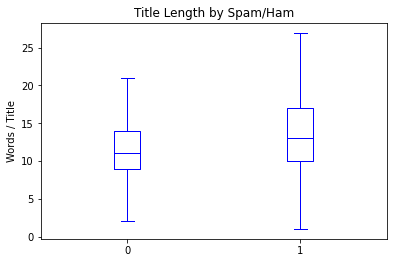

In [5]:
data['text_len'] = data['text'].str.split().apply(len)

data = data[data['text_len'] < 40]

data.boxplot("text_len", by="label", grid=False, showfliers=False, color="Blue")

plt.suptitle('')
plt.title('Title Length by Spam/Ham')
plt.xlabel('')
plt.ylabel('Words / Title')
plt.show()

data = data.drop(columns=['text_len'])


#### Actual Project

#### Convert Pandas DataFrame to Dataset; Then Split into Train/Test/Valid Datasets

In [6]:
# Converts the pandas DataFrame to a Dataset
dataset = Dataset.from_pandas(data)
dataset.shuffle(seed=42)

# Splitting the Dataset into the train, test, and valid datasets and then packing all of them into a Dataset Dictionary
train_testvalid = dataset.train_test_split(test_size=0.20)

test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

dataset = DatasetDict({
    'train': train_testvalid['train'], 
    'test': test_valid['test'], 
    'valid': test_valid['train']})

print('Training data shape:', dataset['train'].shape)
print('Testing data shape:', dataset['test'].shape)
print('Validation data shape:', dataset['valid'].shape)

Training data shape: (19180, 3)
Testing data shape: (2398, 3)
Validation data shape: (2397, 3)


#### Tokenize Entire Dataset

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=max_input_len)

encoded_data = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#### Print Example to Ensure Edits Work as Expected

In [8]:
print(encoded_data['train'].column_names)
print(encoded_data['train'][240])

['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask']
{'text': 'A True War: EA Reveals The Next Battlefield Game Will Take Place In A Divorcing Family', 'label': 1, '__index_level_0__': 11077, 'input_ids': [101, 1037, 2995, 2162, 1024, 19413, 7657, 1996, 2279, 11686, 2208, 2097, 2202, 2173, 1999, 1037, 4487, 14550, 6129, 2155, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


#### Ensure That git lfs is Installed; Remember to Enter Access Token

In [9]:
# HuggingFace Access tokens...

# Used this the first time to install the git lfs; otherwise, it lets me know that git lfs has been initialized
!git lfs install

Git LFS initialized.


#### Instantiate Model

In [10]:
num_labels=2

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

#### Create Compute Performance Metrics Function

In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Instantiate Optimizer (& Learning Rate Scheduler)

In [12]:
logging_steps = round(len(encoded_data["train"]) // batch_size, 0) + 1
optimizer_name = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_training_steps = num_of_epochs * len(dataset['train'])

lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer_name,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

optimizer = [optimizer_name, lr_scheduler]

#### Define TrainingArguments

In [13]:
training_args = TrainingArguments(output_dir=model_name,
                                 num_train_epochs=num_of_epochs,
                                 learning_rate=learning_rate,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 weight_decay=0.01,
                                 evaluation_strategy="epoch",
                                 disable_tqdm=False,
                                 logging_steps=logging_steps,
                                 push_to_hub=True,
                                 log_level="error")

#### Instantiate Trainer

In [14]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics, 
                  train_dataset=encoded_data['train'],
                  eval_dataset=encoded_data['valid'],
                  tokenizer=tokenizer, 
                  optimizers=optimizer)

Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased-OnionOrNot into local empty directory.


#### Train Model

In [15]:
trainer.train()

  0%|          | 0/600 [00:00<?, ?it/s]

{'loss': 0.3334, 'learning_rate': 1.984358706986444e-05, 'epoch': 1.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.23822952806949615, 'eval_accuracy': 0.9023779724655819, 'eval_f1': 0.9010689642400332, 'eval_runtime': 251.1887, 'eval_samples_per_second': 9.543, 'eval_steps_per_second': 0.151, 'epoch': 1.0}
{'loss': 0.1822, 'learning_rate': 1.9687174139728885e-05, 'epoch': 2.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.20392799377441406, 'eval_accuracy': 0.9224030037546934, 'eval_f1': 0.921847601870649, 'eval_runtime': 255.6312, 'eval_samples_per_second': 9.377, 'eval_steps_per_second': 0.149, 'epoch': 2.0}
{'train_runtime': 12803.6661, 'train_samples_per_second': 2.996, 'train_steps_per_second': 0.047, 'train_loss': 0.2578143946329753, 'epoch': 2.0}


TrainOutput(global_step=600, training_loss=0.2578143946329753, metrics={'train_runtime': 12803.6661, 'train_samples_per_second': 2.996, 'train_steps_per_second': 0.047, 'train_loss': 0.2578143946329753, 'epoch': 2.0})

#### Predict Values

In [16]:
output_predictions = trainer.predict(encoded_data['valid'])

output_predictions.metrics

  0%|          | 0/38 [00:00<?, ?it/s]

{'test_loss': 0.20392799377441406,
 'test_accuracy': 0.9224030037546934,
 'test_f1': 0.921847601870649,
 'test_runtime': 257.7233,
 'test_samples_per_second': 9.301,
 'test_steps_per_second': 0.147}

#### Push Fine-Tuned Model to HuggingFace Hub (My Profile)

In [17]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Upload file pytorch_model.bin:   0%|          | 32.0k/255M [00:00<?, ?B/s]

Upload file runs/Sep04_20-59-28_Brians-Mac-mini/events.out.tfevents.1662343176.Brians-Mac-mini.8652.0: 100%|##…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilbert-base-uncased-OnionOrNot
   e980428..baf8c73  main -> main

To https://huggingface.co/DunnBC22/distilbert-base-uncased-OnionOrNot
   baf8c73..3af1419  main -> main



'https://huggingface.co/DunnBC22/distilbert-base-uncased-OnionOrNot/commit/baf8c73ed2ebaad98a1cb7ec54b3cd9fe5b03226'

#### Save Exact Datasets

In [18]:
#dataset['train'].to_csv('OnionOrNot-training_data.csv', index=None)
#dataset['test'].to_csv('OnionOrNot-testing_data.csv', index=None)
#dataset['valid'].to_csv('OnionOrNot-validation_data.csv', index=None)

#### Run Model with Tokenizer Returning 'np' Tensors

In [19]:
num_labels=2
tokenizer2 = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize2(batch):
    return tokenizer2(batch['text'], truncation=True, padding=True, max_length=max_input_len, return_tensors="np")

encoded_data2 = dataset.map(tokenize2, batched=True, batch_size=None)

model2 = (AutoModel.from_pretrained(model_ckpt, num_labels=num_labels, output_hidden_states=True).to(device))

def extract_hidden_states(batch=True):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer2.model_input_names}
    with torch.no_grad():
        last_hidden_state = model2(**inputs)[0]
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

encoded_data2.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

hidden_data = encoded_data2.map(extract_hidden_states, batched=True)

X_train = np.array(hidden_data["train"]["hidden_state"])
X_valid = np.array(hidden_data["valid"]["hidden_state"])
y_train = np.array(hidden_data["train"]["label"])
y_valid = np.array(hidden_data["valid"]["label"])
X_train.shape, X_valid.shape

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

((19180, 768), (2397, 768))

#### Create Function to Calculate & Display Confusion Matrix

In [20]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax)
    plt.title('Normalized Confusion Matrix')
    plt.show()

#### Plot Confusion Matrix for Fine-Tuned Model

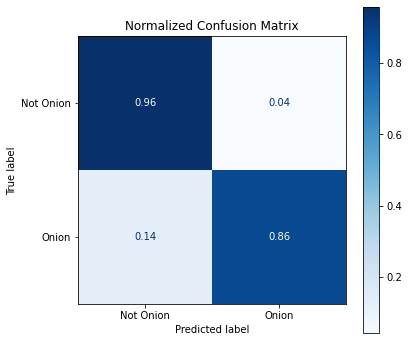

In [26]:
y_preds = np.argmax(output_predictions.predictions, axis=1)
labels = ['Not Onion', 'Onion']

plot_confusion_matrix(y_preds, y_valid, labels)

#### Calculate Logistic Regression for Comparison

In [22]:
log_reg_clf = LogisticRegression(max_iter=3000)
log_reg_clf.fit(X_train, y_train)
log_reg_clf.score(X_valid, y_valid)

0.8781810596579057

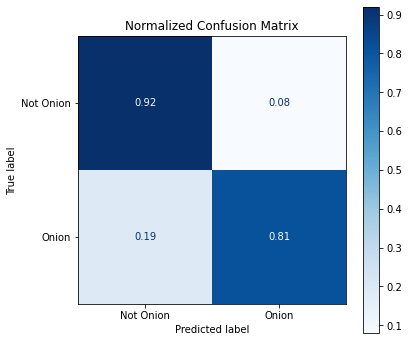

In [23]:
lr_y_preds = log_reg_clf.predict(X_valid)
plot_confusion_matrix(lr_y_preds, y_valid, labels)

#### Calculate Using Dummy Classifier for Comparison

In [24]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy.score(X_valid, y_valid)

0.6203587818105966

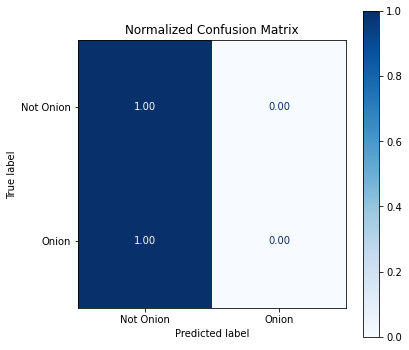

In [25]:
dc_y_preds = dummy.predict(X_valid)
plot_confusion_matrix(dc_y_preds, y_valid, labels)